In [1]:
# THIS CELL SETS STUFF UP FOR DEMO / COLLAB. THIS CELL CAN BE IGNORED.

#-------------------------------------GET RID OF TF DEPRECATION WARNINGS--------------------------------------#
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

#----------------------------------INSTALL PSYCHRNN IF IN A COLAB NOTEBOOK-------------------------------------#
# Installs the correct branch / release version based on the URL. If no branch is provided, loads from master.
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    import json
    import re
    import ipykernel
    import requests 
    from requests.compat import urljoin

    from notebook.notebookapp import list_running_servers
    kernel_id = re.search('kernel-(.*).json',
                          ipykernel.connect.get_connection_file()).group(1)
    servers = list_running_servers()
    for ss in servers:
        response = requests.get(urljoin(ss['url'], 'api/sessions'),
                                params={'token': ss.get('token', '')})
        for nn in json.loads(response.text):
            if nn['kernel']['id'] == kernel_id:
                relative_path = nn['notebook']['path'].split('%2F')
                if 'blob' in relative_path:
                  blob = relative_path[relative_path.index('blob') + 1]
                  !pip install git+https://github.com/murraylab/PsychRNN@$blob
                else:
                  !pip install git+https://github.com/murraylab/PsychRNN

# Curriculum Learning

In [2]:
from psychrnn.tasks.perceptual_discrimination import PerceptualDiscrimination
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.curriculum import Curriculum, default_metric
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

## Instantiate Curriculum Object

We generate a list of tasks that constitute our curriculum. We will train on these tasks one after another. In this example, we train the network on tasks with higher coherence, slowly decreasing to lower coherence.

In [3]:
pds = [PerceptualDiscrimination(dt = 10, tau = 100, T = 2000, N_batch = 50, coherence = .7 - i/5) for i in range(4)]

Set optional parameters for the curriculum object. More information about these parameters is available [here](../apidoc/backend.rst#module-psychrnn.backend.curriculum).

In [4]:
metric = default_metric # Function for calculating whether the stage advances and what the metric value is at each metric_epoch. Default: default_metric().
accuracies = [pds[i].accuracy_function for i in range(len(pds))] # optional list of functions to use to calculate network performance for the purposes of advancing tasks. Used by default_metric() to compute accuracy. Default: [tasks[i].accuracy_function for i in range(len(tasks))].
thresholds = [.9 for i in range(len(pds))] # Optional list of thresholds. If metric = default_metric, accuracies must reach the threshold for a given stage in order to advance to the next stage. Default: [.9 for i in range(len(tasks))]
metric_epoch = 1 # calculate the metric / test if advance to the next stage every metric_epoch training epochs.
output_file = None # Optional path to save out metric value and stage to. Default: None.

Initialize a curriculum object with information about the tasks we want to train on.

In [5]:
curriculum = Curriculum(pds, output_file=output_file, metric_epoch=metric_epoch, thresholds=thresholds, accuracies=accuracies, metric=metric)

## Initialize Models

We add in a few params that Basic(RNN) needs but that PerceptualDiscrimination doesn't generate for us.

In [6]:
network_params = pds[0].get_task_params()
network_params['name'] = 'curriculumModel' #Used to scope out a namespace for global variables.
network_params['N_rec'] = 50

Instantiate two models. *curriculumModel* that will be trained on the series of tasks, pds, defined above. *basicModel* will be trained only on the final task with lowest coherence.

In [7]:
curriculumModel = Basic(network_params)
network_params['name'] = 'basicModel'
basicModel = Basic(network_params)

## Train Models

Set the training parameters for our model to include curriculum. The other training parameters shown in [Simple Example](PerceptualDiscrimination.ipynb) can also be included.

In [8]:
train_params = {}
train_params['curriculum'] = curriculum

We  will train the curriculum model using [train_curric()](../apidoc/backend.rst#psychrnn.backend.rnn.RNN.train_curric) which is a wrapper for [train](../apidoc/backend.rst#psychrnn.backend.rnn.RNN.train) that does't require a task to be passed in outside of the curriculum entry in train_params.

In [9]:
curric_losses, initialTime, trainTime = curriculumModel.train_curric(train_params)

Accuracy: 0.6
Accuracy: 0.62
Accuracy: 0.48
Accuracy: 0.48
Accuracy: 0.44
Accuracy: 0.44
Accuracy: 0.42
Accuracy: 0.5
Accuracy: 0.5
Iter 500, Minibatch Loss= 0.180899
Accuracy: 0.62
Accuracy: 0.46
Accuracy: 0.52
Accuracy: 0.46
Accuracy: 0.52
Accuracy: 0.6
Accuracy: 0.38
Accuracy: 0.6
Accuracy: 0.6
Accuracy: 0.4
Iter 1000, Minibatch Loss= 0.114158
Accuracy: 0.48
Accuracy: 0.44
Accuracy: 0.5
Accuracy: 0.5
Accuracy: 0.58
Accuracy: 0.98
Stage 1
Accuracy: 1.0
Stage 2
Accuracy: 1.0
Stage 3
Accuracy: 0.92
Stage 4
Optimization finished!


Set training parameters for the non-curriculum model. We use performance_measure and cutoff so that the model trains until it 90% accurate on the hardest task, just like the curriculum model does. This will give us a more fair comparison when we look at losses and training time

In [10]:
def performance_measure(trial_batch, trial_y, output_mask, output, epoch, losses, verbosity):
    return pds[len(pds)-1].accuracy_function(trial_y, output, output_mask)

train_params['curriculum'] = None
train_params['performance_measure'] = performance_measure
train_params['performance_cutoff'] = .9

Train the non-curriculum model.

In [11]:
basic_losses, initialTime, trainTime= basicModel.train(pds[len(pds)-1], train_params)

performance: 0.54
performance: 0.6
performance: 0.42
performance: 0.54
performance: 0.26
performance: 0.24
performance: 0.58
performance: 0.42
performance: 0.52
Iter 500, Minibatch Loss= 0.102338
performance: 0.56
performance: 0.56
performance: 0.46
performance: 0.48
performance: 0.56
performance: 0.54
performance: 0.52
performance: 0.5
performance: 0.54
performance: 0.56
Iter 1000, Minibatch Loss= 0.084302
performance: 0.4
performance: 0.48
performance: 0.52
performance: 0.44
performance: 0.46
performance: 0.5
performance: 0.64
performance: 0.38
performance: 0.52
performance: 0.56
Iter 1500, Minibatch Loss= 0.093645
performance: 0.44
performance: 0.5
performance: 0.46
performance: 0.5
performance: 0.4
performance: 0.5
performance: 0.46
performance: 0.6
performance: 0.6
performance: 0.56
Iter 2000, Minibatch Loss= 0.082302
performance: 0.58
performance: 0.4
performance: 0.46
performance: 0.5
performance: 0.46
performance: 0.54
performance: 0.62
performance: 0.46
performance: 0.42
perfo

### Plot Losses

Plot the losses from curriculum and non curriculum training.

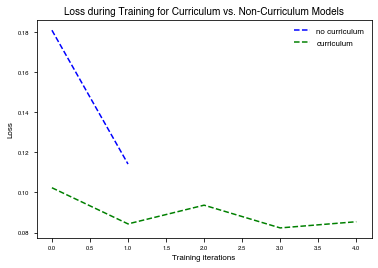

In [12]:
plt.plot( curric_losses, 'b--', label = 'no curriculum')
plt.plot(basic_losses, 'g--', label='curriculum')
plt.legend()
plt.title("Loss during Training for Curriculum vs. Non-Curriculum Models")
plt.ylabel('Loss')
plt.xlabel('Training iterations')
plt.show()

## Cleanup

In [13]:
basicModel.destruct()

In [14]:
curriculumModel.destruct()